In [1]:
# personally made imports
import acquire_p
import analysis_p

# typical imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# modeling methods
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#clean look
import warnings
warnings.filterwarnings("ignore")

get_bilancino_data()
prepare(df)


<Figure size 432x288 with 0 Axes>

# Report on Acea Smart Water Analytics
    By Jessica Gardin

## Data Dictionary

Rainfall_S_Piero    - rainfall in mm \
Rainfall_Mangona    - rainfall in mm \
Rainfall_S_Agata    - rainfall in mm \
Rainfall_Cavallina  - rainfall in mm \
Rainfall_Le_Croci   - rainfall in mm \
Temperature_Le_Croci - temperature in 'C \
Lake_Level - level in meters (m) \
Flow_Rate - flow rate in cubic meters per second (mc/s) \
avg_rain - avg of Mangona, S_Agata, Le_Croci rainfall


## Steps to reproduce

You will need a kaggle account.
https://www.kaggle.com/competitions/acea-water-prediction

Clone my repo (including the acquire_p.py)

Libraries used are pandas, matplotlib, seaborn, numpy, sklearn, datetime, math, statsmodels, and scipy.stats.


## Project Goals

Forcast water levels in Lake Bilancino to aid environmental services in determining how to handle daily consumptions efficiently.

## Project Desciption

As climate change impacts weather patterns, water may become increasingly in short supply. Learning how to predict and effecitvely manage water supplies, especially fresh water supplies, is crucial for city development and human survival. 

## Initial Testing and Hypothesis
1. Rain affects water levels in the lake
2. Temperature affects water levels in the lake
3. Flow rate out of the lake affects water levels in the lake

# Acquire
https://www.kaggle.com/competitions/acea-water-prediction/discussion/202747

Data was acquired from Kaggle in the form of a .csv file

In [2]:
lake = acquire_p.get_bilancino_data()

# Prepare
- two years of missing data was deleted

In [3]:
lake = acquire_p.prepare(lake)
lake.head()

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,,,,,,
2005-01-01,0.0,0.0,0.0,0.0,0.0,6.20,249.84,0.6
2005-01-02,0.0,0.0,0.0,0.0,0.0,4.55,250.63,0.6
2005-01-03,0.0,0.0,0.0,0.0,0.0,-2.00,250.72,0.6
2005-01-04,0.0,0.0,0.0,0.0,0.0,12.45,252.07,9.5
2005-01-05,0.0,0.0,0.0,0.0,0.0,20.00,252.05,6.5


# Explore/Feature Engineering

# Visual

In [4]:
example_m = analysis_p.example

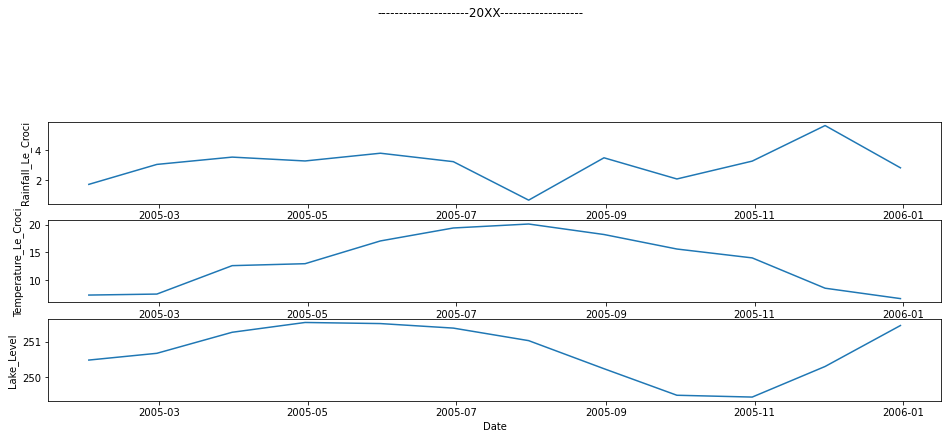

In [5]:
analysis_p.visual(example_m)

# Visual Takeaway
Data illustrates a 3 month time delay between independent variables and their effect on the Lake level. 
I chose to shift these variables by 3 months. 

# Statistical Exploration

- All continuous variables so Spearman or Pearson
- Spearman is better with monotonic patterns and skewed data set, both of which apply to this dataset

<AxesSubplot:>

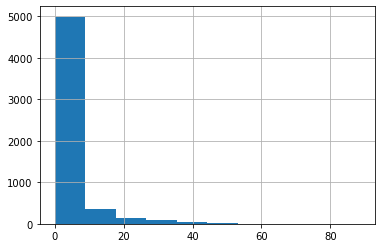

In [6]:
lake.Rainfall_Le_Croci.hist()

### No shift

In [7]:
cat_col = lake.columns

In [8]:
stat_norm = []

In [9]:
for col in cat_col:
    stats.spearmanr(lake.Lake_Level, lake[col])
    stat_norm.append(stats.spearmanr(lake.Lake_Level, lake[col]))

In [10]:
stat_norm = pd.DataFrame(stat_norm, index = cat_col).round(4)

### 3 Month Shift
3 months is appoximately 90 days

In [11]:
lake_s = acquire_p.get_bilancino_data()

In [12]:
lake_s = acquire_p.prepare(lake_s)

In [13]:
lake_s[['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata',
       'Rainfall_Cavallina', 'Rainfall_Le_Croci', 'Temperature_Le_Croci']] = lake_s[['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata',
       'Rainfall_Cavallina', 'Rainfall_Le_Croci', 'Temperature_Le_Croci']].shift(periods = 90, fill_value=0)

In [14]:
lake_s = lake_s[lake_s.index >= '2005-04-01']

In [15]:
cat_col = lake_s.columns

In [16]:
stat_3m_s = []

In [17]:
for col in cat_col:
    stats.spearmanr(lake_s.Lake_Level, lake_s[col])
    stat_3m_s.append(stats.spearmanr(lake_s.Lake_Level, lake_s[col]))

In [18]:
stat_3m_s = pd.DataFrame(stat_3m_s, index = cat_col, columns = ['corr_3m_s', 'p_3m_s']).round(4)

# Compare

In [19]:
stat_sum = stat_norm.join(stat_3m_s)

In [20]:
stat_sum_cor = stat_sum[['correlation', 'corr_3m_s']]

In [21]:
stat_sum_cor = stat_sum_cor.abs()

In [22]:
stat_sum_cor = stat_sum_cor.drop(index = ['Flow_Rate', 'Lake_Level'])

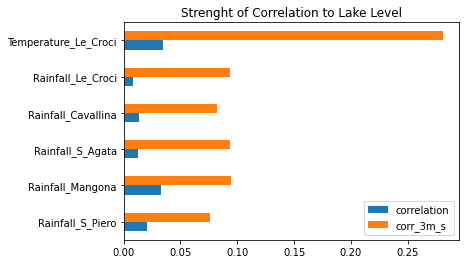

In [23]:
spear_cor = stat_sum_cor.plot(kind = 'barh', title = 'Strenght of Correlation to Lake Level')

In [24]:
stat_sum_p = stat_sum[['pvalue', 'p_3m_s']]

In [25]:
stat_sum_p = stat_sum_p.drop(index = ['Flow_Rate', 'Lake_Level'])

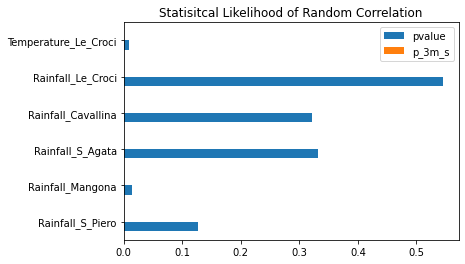

In [26]:
spear_p = stat_sum_p.plot(kind = 'barh', title = 'Statisitcal Likelihood of Random Correlation')

# Concerns for sparse matrix

In [27]:
lake.describe().round(2)

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
count,5660.00,5660.00,5660.00,5660.00,5660.00,5660.00,5660.00,5660.00
mean,2.48,3.34,2.70,2.66,3.13,14.57,249.51,2.71
std,6.73,8.97,7.28,7.71,8.09,6.93,2.19,4.01
min,0.00,0.00,0.00,0.00,0.00,-5.35,243.53,0.45
25%,0.00,0.00,0.00,0.00,0.00,9.10,247.89,0.60
50%,0.00,0.00,0.00,0.00,0.00,14.50,250.19,1.50
75%,0.80,1.20,1.20,0.40,1.20,20.15,251.28,3.00
max,80.60,110.00,120.20,113.60,88.40,34.00,252.76,74.65


# Takeaway
based on stats testing and high amounts of zeros in data, 
I intend to comibne Rainfall Mangona, Agata, and Le_Croci

I will drop Rainfall S_Piero and Cavallina

In [28]:
lake_s['avg_rain'] = (lake_s.Rainfall_Mangona + lake_s.Rainfall_S_Agata + lake_s.Rainfall_Le_Croci)/3

In [29]:
cat_col = lake_s.columns

In [30]:
stat_spars = []

In [31]:
for col in cat_col:
    stats.spearmanr(lake_s.Lake_Level, lake_s[col])
    stat_spars.append(stats.spearmanr(lake_s.Lake_Level, lake_s[col]))

In [32]:
stat_spars = pd.DataFrame(stat_spars, index = cat_col, columns = ['corr_spars', 'p_spars']).round(4)

In [33]:
stat_spars = stat_spars.abs()

In [34]:
stat_spars = stat_spars.drop(index = ['Flow_Rate', 'Lake_Level'], columns = 'p_spars')

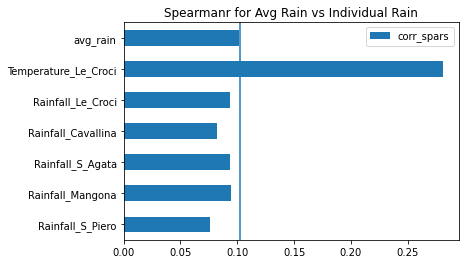

In [35]:
ax = stat_spars.plot(kind = 'barh', title = 'Spearmanr for Avg Rain vs Individual Rain')
plt.axvline(.102)

# Takeaway
avg rainfall has a stronger correlation with the target variable than any individual rain dataset

# Initial Testing and Hypothesis
1. Rain affects water levels in the lake
    - True. Specifically Le_Croci, S_Agata, and Mangona
2. Temperature affects water levels in the lake
    - True.
3. Flow rate out of the lake affects water levels in the lake
    - True.

# Model

### Split Data
16 years of data \
Human split

9 years to train (55%) \
4 years to validate (25%) \
3 years to test (20%)

In [36]:
mod_col = lake_s.drop(columns = ['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata',
       'Rainfall_Cavallina', 'Rainfall_Le_Croci'])

In [37]:
mod_col = mod_col.resample('M').mean()

In [38]:
train = mod_col[mod_col.index < '2014-01-01']
validate = mod_col[(mod_col.index >= '2014-01-01') & (mod_col.index < '2018-01-01')]
test = mod_col[mod_col.index >= '2018-01-01']

In [39]:
trainx = train.drop(columns = 'Lake_Level')
trainy = train.Lake_Level

validatex = validate.drop(columns = 'Lake_Level')
validatey = validate.Lake_Level

testx = test.drop(columns = 'Lake_Level')
testy = test.Lake_Level

In [40]:
train.shape, validate.shape, test.shape

((105, 4), (48, 4), (36, 4))

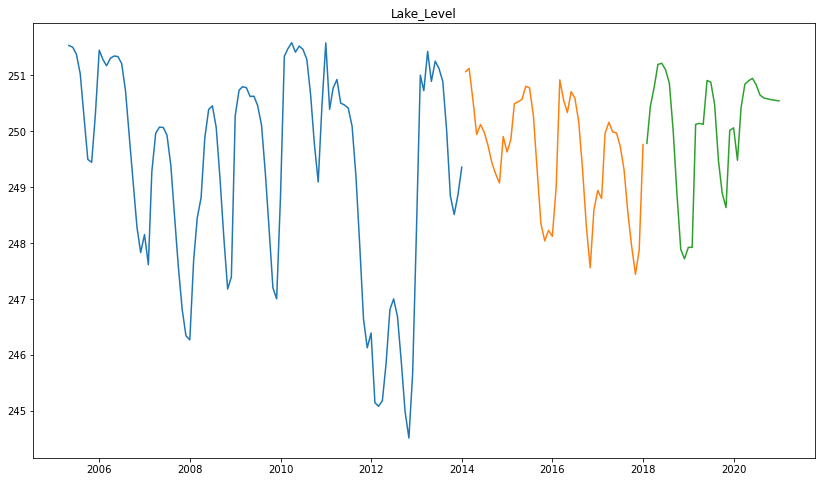

In [41]:
plt.figure(figsize=(14,8))
plt.plot(train.Lake_Level)
plt.plot(validate.Lake_Level)
plt.plot(test.Lake_Level)
plt.title("Lake_Level")
plt.show()



In [42]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'rmse'])
eval_df

,model_type,rmse


In [43]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [44]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(rmse)
    plt.show()

In [45]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Simple Avg

In [46]:
avg_train = trainy.mean()

In [47]:
yhat_df = pd.DataFrame(
    {'Lake_Level': [avg_train]},
    index=validate.index)

yhat_df.head()

,Lake_Level
Date,
2014-01-31,249.312891
2014-02-28,249.312891
2014-03-31,249.312891
2014-04-30,249.312891
2014-05-31,249.312891


1.0234


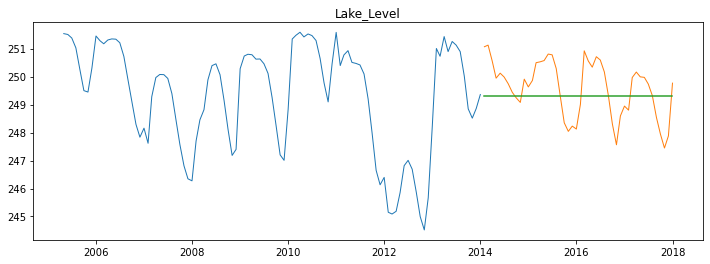

In [48]:
plot_and_eval('Lake_Level')

In [49]:
eval_df = append_eval_df(model_type = 'simple_avg', target_var = 'Lake_Level')

eval_df

,model_type,rmse
0,simple_avg,1.0234


# Holt's Linear Trend

### FIT ONLY ON TRAIN

In [50]:
col = 'Lake_Level' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [51]:
# fit the holt's object
model = model.fit(optimized=True)

In [52]:
yhat = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [53]:
yhat_df = pd.DataFrame(yhat.round(2), columns = ['Lake_Level'])

yhat_df.head()

,Lake_Level
2014-01-31,249.70
2014-02-28,249.97
2014-03-31,250.19
2014-04-30,250.36
2014-05-31,250.50


1.7568


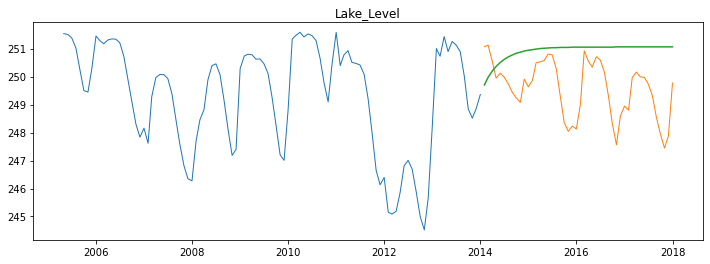

In [54]:
plot_and_eval('Lake_Level')

In [55]:
eval_df = append_eval_df(model_type = "Holt's_Linear", target_var = 'Lake_Level')

eval_df

,model_type,rmse
0,simple_avg,1.0234
1,Holt's_Linear,1.7568


# Prediction Based on Previous cycle

In [56]:
# finding the year-over-year difference for each month
# taking the mean, and then adding that value to the monthy cycle before validate series

# find yoy diff. in train data set take the mean, and add to each value in cycle before validate. 
yhat_df = trainy['2013'] + trainy.diff(12).mean()

In [57]:
# validate is 4 years

In [58]:
yhat_df = pd.concat([yhat_df,yhat_df], axis = 0)

In [59]:
yhat_df = pd.concat([yhat_df,yhat_df], axis = 0)

In [60]:
yhat_df.index = validate.index

In [61]:
yhat_df = pd.DataFrame(yhat_df.round(4), columns = ['Lake_Level'])

0.8684


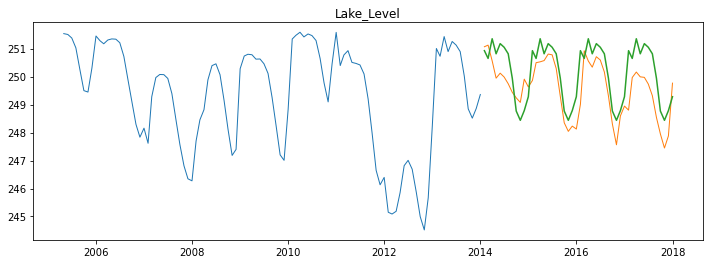

In [62]:
plot_and_eval('Lake_Level')

In [63]:
eval_df = append_eval_df(model_type = "Previous_cycle", target_var = 'Lake_Level')

eval_df

,model_type,rmse
0,simple_avg,1.0234
1,Holt's_Linear,1.7568
2,Previous_cycle,0.8684


# Test
## Previous cycle was the best.

#Only learn from train so learn from train then add to validate since validate is the cycle before test

In [71]:
yhat_df = validatey['2017'] + trainy.diff(12).mean()

In [72]:
yhat_df.shape, test.shape

((12,), (36, 4))

In [73]:
yhat_df2 = pd.concat([yhat_df,yhat_df], axis = 0)

In [74]:
yhat_df3 = pd.concat([yhat_df2,yhat_df], axis = 0)

In [75]:
yhat_df3.shape, test.shape

((36,), (36, 4))

In [78]:
yhat_df3.index = test.index

In [79]:
yhat_df = pd.DataFrame(yhat_df3.round(4), columns = ['Lake_Level'])

In [81]:
yhat_df.shape, test.shape

((36, 1), (36, 4))

In [82]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 4)
    return rmse

In [83]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(test[target_var], label='Test', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(rmse)
    plt.show()

In [84]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

1.3713


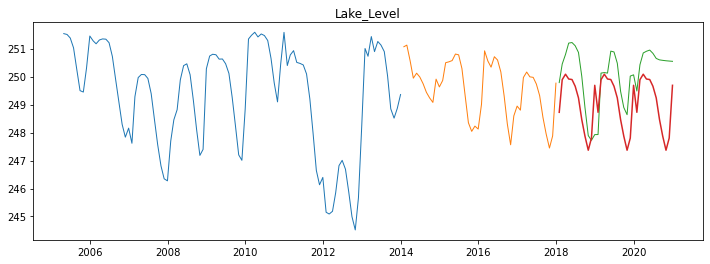

In [85]:
plot_and_eval('Lake_Level')

# Conclusion
## Report Findings 
1. Rain affects water levels in the lake
    - True. Specifically Le_Croci, S_Agata, and Mangona
2. Temperature affects water levels in the lake
    - True.
3. Flow rate out of the lake affects water levels in the lake
    - True.

### 'Previous Cycle' was the most effective model based on RMSE scores
### Most effective feature engineering:
    - 1 M resampling period
    - 3 M shift in rainfall and temperature
    - taking avg of three most strongly correlated rainfalls: Le_Croci, S_Agata, and Mangona



##  Recommendations and Future Work

- combine model with models that predict changes in temperature and rainfall to get a more accurate

- regulate water usage to minimize use of limited water resources

- invest in salt-water conversion to fresh water
